In [1]:
#导入包
from torchvision.models import vgg19#导入预处理模型VGG19
from torchvision import transforms as T
from torch.nn import functional as F
from torch_snippets import *
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = 'cuda' if torch.cuda.is_available() else 'cpu'#引入GPU加速训练，若无GPU则使用CPU。

In [2]:
#定义用于预处理数据的函数
preprocess = T.Compose([
    T.ToTensor(),#将输入图像转换为张量，并进行缩放。
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),#对张量进行标准化处理。（设置了RGB三通道的均值和方差）
    T.Lambda(lambda x: x.mul_(255))#将标准化后的张量重新放大至[0,255]。
])
#定义用于后处理数据的函数：便于后续可视化处理。
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),#将输入张量缩放至[0,1]。
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])#对预处理的操作进行逆向操作。
])

In [3]:
#定义Gram矩阵：计算输入特征图的Gram矩阵，用于捕获图像的风格信息。
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)#通过矩阵乘法计算通道间的相关性。
        G.div_(h*w)#进行归一化，避免因尺寸不同导致数值差异。
        return G
#计算两个特征图的Gram矩阵之间的均方误差损失，用于衡量生成图像与目标风格图像在风格上的差异。
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
#定义VGG19模型
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()#初始化
        #提取特征，加载预训练VGG19模型的特征提取部分。
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()#固定一部分参数。
    def forward(self, x, layers=[]):
        """
        定义前向传播方法。
        :param x:输入图像。
        :param layers:需要提取特征的层索引列表。
        传播流程：
        1. 按顺序遍历VGG19的每一层，对输入进行处理。
        2.当遇到layers中指定的层时，保存该层的输出特征。
        3.最终按layers中指定的顺序返回提取的特征。
        """
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [4]:
vgg = vgg19_modified().to(device)#定义模型对象，并将模型迁移至GPU上加速训练。

D:\Anaconda3\envs\DarkKnight\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\envs\DarkKnight\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#从指定路径导入内容图像和风格图像，并确保图像大小为相同形状，即512*512*3.
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in [r'D:\PythonProject\pythonProject\实验\深度学习实验\任务一 风格迁移\png\starry_night.jpg',r'D:\PythonProject\pythonProject\实验\深度学习实验\任务一 风格迁移\png\tyut.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [6]:
#指定需要修改的内容图像
opt_img = content_image.data.clone()#初始化生成图像
opt_img.requires_grad = True#允许PyTorch跟踪生成图像的相关操作，以便后续通过反向传播计算梯度。

In [7]:
#指定用于计算内容损失和风格损失的层。即指定使用VGG模型的哪个中间层来比较风格图像Gram矩阵和内容图像的原始特征向量。
#VGG19包含16个卷积层和5个池化层
style_layers = [0, 5, 10, 19, 28]#风格层：保留图像的浅层细节和深层结构
content_layers = [21]#内容层：捕获图像的高级语义内容，保留物体形状和空间关系。
loss_layers = style_layers + content_layers#提取VGG19的多尺度特征。

In [8]:
#定义内容损失函数和风格损失函数
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [9]:
#定义与内容损失和风格损失相关的权重
style_weights = [1000/n**2 for n in [64,128,256,512,512]]#风格权重：通道数越多的层，权重越小。
content_weights = [1]#内容权重：固定为1，避免生成图像偏离原始内容。
weights = style_weights + content_weights#合并权重

In [10]:
#对图像进行操作，使得目标图像的风格尽可能相似。
#生成图像同时满足：内容匹配（生成图像的内容特征接近内容图像的特征）和风格匹配（生成图像的风格特征接近风格图像）
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [11]:
#定义优化器和迭代次数
#这里使用L-BFGS算法优化生成图像，相较于Adam优化器，其属于二阶优化、收敛速度更快、无需调整学习率等，但计算复杂度高。
optimizer = optim.LBFGS([opt_img])
max_iters = 800

In [12]:
# 使用tqdm创建进度条
for iters in tqdm(range(max_iters), desc="Optimizing"):
    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        return loss
 
    optimizer.step(closure)

Optimizing: 100%|████████████████████████████████████████████████████████████████████| 800/800 [26:38<00:00,  2.00s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7640689..1.4261571].


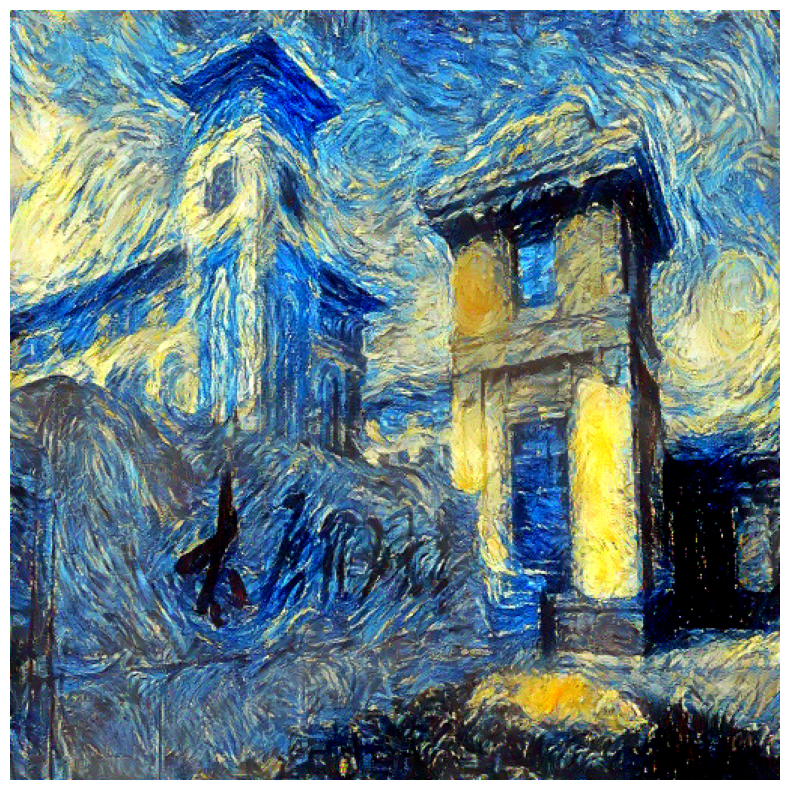

In [13]:
#使用内容图像和风格图像的组合进行图像绘制
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)